In [1]:
import xarray as xr
import netCDF4 as nc 
import pandas as pd
import glob
import datetime
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from timezonefinder import TimezoneFinder
import pytz
import pickle

In [2]:
csv_file_path='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/pyrocb_events.csv'
events_df = pd.read_csv(csv_file_path)
elevation_df=pd.read_csv('/Users/liuyangfan/Desktop/Stanford/pyrocast-database/elevation_data_export.csv')
elevation_df=elevation_df[['elevation','pyroCb_id']]
events_df=pd.merge(events_df,elevation_df,on='pyroCb_id',how='left')
events_df2=events_df[events_df['elevation'].notna() & events_df['pyroCb_time_utc'].notna()]
monthly_pressure_directory = '/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/pyroCb_events_pressure_level_monthly/'
monthly_single_directory = '/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/pyroCb_events_single_level_monthly/'
pressure_directory = '/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/pyroCb_events_pressure_level/'
single_directory = '/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/pyroCb_events_single_level/'
ts_save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/timeseries/'
tdiff_save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/timediff/'
pk_save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/pickles/'

In [3]:
def calculate_wind_direction(u, v):
    direction = math.atan2(-u, -v)
    direction = math.degrees(direction)
    direction = (direction + 360) % 360  # Adjust to 0-360 degrees if necessary
    return direction

def wind_speed_knots(u, v):
    # Calculate wind speed in m/s
    wind_speed_m_per_s = math.sqrt(u**2 + v**2)
    # Convert m/s to knots
    wind_speed_knots = wind_speed_m_per_s * 1852 / 3600
    return wind_speed_knots

def wind_speed_m_per_s(u, v):
    # Calculate wind speed in m/s
    wind_speed_m_per_s = math.sqrt(u**2 + v**2)
    return wind_speed_m_per_s

def calculate_dew_point(T,RH):# input T is in Kelvin
    # Constants
    T0 = 273.15  # Reference temperature in K
    E0 = 611.2  # Saturated water vapor pressure at T0 in Pa
    L = 2.45e6  # Latent heat of vaporization in J/kg
    Rv = 461.5  # Specific gas constant for water vapor in J/(kg·K)   
    # Calculate E(T) using the Clausius-Clapeyron equation
    E_T = E0 * math.exp((L / Rv) * ((1 / T0) - (1 / T)))    
    # calculate saturation water vapor pressure at T_d
    E_T_d = E_T * RH/100
    # Calculate T using the rearranged Clausius-Clapeyron equation
    T_d = 1 / ((1 / T0) - ((Rv / L) * math.log(E_T_d / E0)))-273.15
    return T_d

def calculate_surface_RH(T,T_d):# input T is in Kelvin
    # Constants
    T0 = 273.15  # Reference temperature in K
    E0 = 611.2  # Saturated water vapor pressure at T0 in Pa
    L = 2.45e6  # Latent heat of vaporization in J/kg
    Rv = 461.5  # Specific gas constant for water vapor in J/(kg·K)   
    # Calculate E(T) using the Clausius-Clapeyron equation
    E_T = E0 * math.exp((L / Rv) * ((1 / T0) - (1 / T)))    
    E_T_d = E0 * math.exp((L / Rv) * ((1 / T0) - (1 / T_d)))  
    # calculate saturation water vapor pressure at T_d
    RH=E_T_d/E_T*100
    return RH
    
# Function to convert Unix timestamp to local hour
def ut_to_local_time(ut_time, tz):
    local_time = ut_time.replace(tzinfo=pytz.utc).astimezone(tz)
    return local_time

tf = TimezoneFinder()

def calculate_wind_diff(u0,v0,u1,v1):
    dir_diff=calculate_wind_direction(u1, v1)-calculate_wind_direction(u0, v0)
    speed_diff=wind_speed_m_per_s(u1, v1)-wind_speed_m_per_s(u0, v0)
    vector_diff_dir=calculate_wind_direction(u1-u0, v1-v0)
    vector_diff_speed=wind_speed_m_per_s(u1-u0, v1-v0)
    return [dir_diff, speed_diff, vector_diff_dir, vector_diff_speed]

# Function to determine the geographical area
def determine_centers_to_interpolate(longitude, latitude):
    # Adjusting the coordinates to the nearest 0.25 degree grid
    north = latitude + 0.25 - (latitude % 0.25)
    south = latitude - (latitude % 0.25)
    east = longitude + 0.25 - (longitude % 0.25)
    west = longitude - (longitude % 0.25)
    latcen=north/2+south/2
    loncen=east/2+west/2
    if longitude<loncen:
        nearest_lon=west
    if longitude>loncen:
        nearest_lon=east
    if latitude<latcen:
        nearest_lat=south
    if latitude>latcen:
        nearest_lat=north
    lonlist=[]
    latlist=[]
    if longitude==loncen and latitude == latcen:# locates in the center of 4 points
        lonlist=[west,east]
        latlist=[south,north]
    elif latitude == latcen:# locates in the center of 2 vertical points
        lonlist=[nearest_lon]
        latlist=[south,north]
    elif longitude==loncen:# locates in the center of 2 horizontal points
        lonlist=[west,east] 
        latlist=[nearest_lat] 
    else:
        lonlist=[nearest_lon] 
        latlist=[nearest_lat]
    return {'lonlist':lonlist,'latlist':latlist}

def calculate_theta_e(t,p,q):
    # calculate saturation vapor pressure
    L = 2.45e6  # Latent heat of vaporization in J/kg
    Cp = 1005
    # potential temperature
    theta = t*((1000/p)**(287/1005))
    theta_e=theta*math.exp((L*q)/(Cp*t))
    return theta_e

1. name a variable
2. choose an event
3. get the year, hour, location and mid troposphere upper boundary from the csv file
4. open the pressure file 
5. get the variable
6. do spatial and temporal interpolation to get the variable for the specific event
7. get the variable timeseries for 96 hours                                                           
8. open the background pressure file
9. get the variable
10. match the timeseries of the variable with the timeseries of PyroCb event
11. add to a dataframe for this PyroCb event: rows are hours, cols are params                              

In [4]:
eventcnt=0
for INDEX, row in events_df.iterrows():
    # Skip rows without PyroCb time information
    if pd.isna(row['pyroCb_time_utc']):
        continue
    if(int(row['pyroCb_time_utc'])>2359):
        continue
    # Formatting the event time
    
    eventcnt=eventcnt+1
    if eventcnt<55:
        continue
    else:
        print(eventcnt)
        # 1. choose an event
        #row=events_df.iloc[0]#row['pyroCb_id'] gets the id
        p_path=os.path.join(pressure_directory, str(row['pyroCb_id'])+'/*.nc')
        s_path=os.path.join(single_directory, str(row['pyroCb_id'])+'/*.nc')
        monthly_p_path=os.path.join(monthly_pressure_directory, str(row['pyroCb_id'])+'/24hrs.nc')
        monthly_s_path=os.path.join(monthly_single_directory, str(row['pyroCb_id'])+'/24hrs.nc')
        
        # 2. get the year, hour, location, and mid troposphere upper boundary from the csv file as well as the local time series
        event_time = f"{row['pyroCb_date_utc']} {int(row['pyroCb_time_utc']):04d}"
        event_datetime = datetime.datetime.strptime(event_time, '%Y-%m-%d %H%M')
        yr=event_datetime.year
        mon=event_datetime.month
        hr=event_datetime.hour
        lon=row['pyroCb_longitude']
        lat=row['pyroCb_latitude']
        country=row['country']
        region=row['region']
        
        # upper troposphere level (for divergence calculation)
        if lat > 60:
            tp=300
        else:
            tp=250
        
        # upper bound of mid troposphere(under jet stream) (for mid tropo RH calculation)
        if lat > 60:
            mh2 = 400 
        else:
            mh2 = 300
            
        
        # local timeseries
        time_before=event_datetime - datetime.timedelta(hours=48)
        UT_times=[time_before]
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            UT_times.append(time_after)   
        # Find the timezone for the given coordinates
        timezone_str = tf.timezone_at(lng=lon, lat=lat)
        timezone = pytz.timezone(timezone_str)
        # Convert each Unix timestamp to local hour
        local_times = [ut_to_local_time(ts, timezone) for ts in UT_times]
        
        ## build a dataframe for the event which will contain all bg and anomaly variable series
        eventvardf=pd.DataFrame({'pyroCb_id':[row['pyroCb_id']]*97,'hour_index':list(range(1,98)),'UT_time':UT_times,'Local_time':local_times})
        
        # 3. open the relavent files
        sfile=xr.merge([xr.open_dataset(f) for f in glob.glob(s_path)])
        s_monthly_file=xr.open_dataset(monthly_s_path)
        pfile=xr.merge([xr.open_dataset(f) for f in glob.glob(p_path)])
        p_monthly_file=xr.open_dataset(monthly_p_path)
        
        # select one location to estimate PyroCb meteor
        centers_to_use=determine_centers_to_interpolate(lon,lat)
        if len(centers_to_use['latlist'])==1 and len(centers_to_use['lonlist'])==1:
            sfile=sfile.sel(longitude=centers_to_use['lonlist'][0],
                 latitude=centers_to_use['latlist'][0])# latitude slice is from large to small
            s_monthly_file=s_monthly_file.sel(longitude=centers_to_use['lonlist'][0],
                 latitude=centers_to_use['latlist'][0])# latitude slice is from large to small
            pfile=pfile.sel(longitude=centers_to_use['lonlist'][0],
                 latitude=centers_to_use['latlist'][0])# latitude slice is from large to small
            p_monthly_file=p_monthly_file.sel(longitude=centers_to_use['lonlist'][0],
                 latitude=centers_to_use['latlist'][0])# latitude slice is from large to small
        if len(centers_to_use['latlist'])==2 and len(centers_to_use['lonlist'])==1:
            sfile=sfile.sel(longitude=centers_to_use['lonlist'][0]).interp(latitude=lat)
            s_monthly_file=s_monthly_file.sel(longitude=centers_to_use['lonlist'][0]).interp(latitude=lat)
            pfile=pfile.sel(longitude=centers_to_use['lonlist'][0]).interp(latitude=lat)
            p_monthly_file=p_monthly_file.sel(longitude=centers_to_use['lonlist'][0]).interp(latitude=lat)
        if len(centers_to_use['latlist'])==1 and len(centers_to_use['lonlist'])==2:
            sfile=sfile.sel(latitude=centers_to_use['latlist'][0]).interp(longitude=lon)
            s_monthly_file=s_monthly_file.sel(latitude=centers_to_use['latlist'][0]).interp(longitude=lon)
            pfile=pfile.sel(latitude=centers_to_use['latlist'][0]).interp(longitude=lon)
            p_monthly_file=p_monthly_file.sel(latitude=centers_to_use['latlist'][0]).interp(longitude=lon)
        if len(centers_to_use['latlist'])==2 and len(centers_to_use['lonlist'])==2:
            sfile=sfile.interp(longitude=lon,latitude=lat)
            s_monthly_file=s_monthly_file.interp(longitude=lon,latitude=lat)
            pfile=pfile.interp(longitude=lon,latitude=lat)
            p_monthly_file=p_monthly_file.interp(longitude=lon,latitude=lat)
    
    
        # build the dataframe to store data
        eventvardf=pd.DataFrame({'pyroCb_id':[row['pyroCb_id']]*97,'hour_index':list(range(1,98)),'UT_time':UT_times,'Local_time':local_times})
    
        ###################### define mh1 and lower TROPOSphere here
        # remove nan and calculate mean value 
        time_before=event_datetime - datetime.timedelta(hours=48)
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        surfz=sfile['z'].interp(time=time_before).item()
        blhz=sfile['blh'].interp(time=time_before).item()*9.8+surfz
        cbhz=sfile['cbh'].interp(time=time_before).item()*9.8+surfz
        surfz_monthly=s_monthly_file['z'].interp(time=bg_time_before).item()
        blhz_monthly=s_monthly_file['blh'].interp(time=bg_time_before).item()*9.8+surfz
        cbhz_monthly=s_monthly_file['cbh'].interp(time=bg_time_before).item()*9.8+surfz
        hz_timeseries={'blhz':[blhz_monthly,blhz],'cbhz':[cbhz_monthly,cbhz]}
        
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            surfz=sfile['z'].interp(time=time_after).item()
            blhz=sfile['blh'].interp(time=time_after).item()*9.8+surfz
            cbhz=sfile['cbh'].interp(time=time_after).item()*9.8+surfz
            surfz_monthly=s_monthly_file['z'].interp(time=bg_time_after).item()
            blhz_monthly=s_monthly_file['blh'].interp(time=bg_time_after).item()*9.8+surfz
            cbhz_monthly=s_monthly_file['cbh'].interp(time=bg_time_after).item()*9.8+surfz
            hz_timeseries['blhz'].extend([blhz_monthly,blhz])
            hz_timeseries['cbhz'].extend([cbhz_monthly,cbhz])
    
        
        cbhz=np.nanmean(np.array(hz_timeseries['cbhz']))
        blhz=np.nanmin(hz_timeseries['blhz'])
        
        ## get the 97 h background timeseries
        ############################################################################################################
        ######################################## variables ########################################################
        #################################### 1. Surface ##################################
        ################### 1.1 surface RH ###################
        variable='surface_RH_2m'
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        ## for single level vars
        var_timeseries=[calculate_surface_RH(sfile['t2m'].interp(time=time_before).item(),
                                             sfile['d2m'].interp(time=time_before).item())]
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            var_timeseries.append(calculate_surface_RH(sfile['t2m'].interp(time=time_after).item(),
                                             sfile['d2m'].interp(time=time_after).item()))   
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        bg_var_timeseries=[calculate_surface_RH(s_monthly_file['t2m'].interp(time=bg_time_before).item(),
                                             s_monthly_file['d2m'].interp(time=bg_time_before).item())]
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            bg_var_timeseries.append(calculate_surface_RH(s_monthly_file['t2m'].interp(time=bg_time_after).item(),
                                             s_monthly_file['d2m'].interp(time=bg_time_after).item()))   
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig)
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        ######################################################
        
         
        ################ 1.2 surface windspeed ###############
        variable='surface_windspeed_10m'
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        ## for single level vars
        var_timeseries=[wind_speed_m_per_s(sfile['u10'].interp(time=time_before).item(),
                                             sfile['v10'].interp(time=time_before).item())]
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            var_timeseries.append(wind_speed_m_per_s(sfile['u10'].interp(time=time_after).item(),
                                             sfile['v10'].interp(time=time_after).item()))  
        
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        bg_var_timeseries=[wind_speed_m_per_s(s_monthly_file['u10'].interp(time=bg_time_before).item(),
                                             s_monthly_file['v10'].interp(time=bg_time_before).item())]
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            bg_var_timeseries.append(wind_speed_m_per_s(s_monthly_file['u10'].interp(time=bg_time_after).item(),
                                             s_monthly_file['v10'].interp(time=bg_time_after).item()))   
        
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ######################################################
        
        
        ######################################################################################################
        ###############################2. single level directly derived variable #############################
        singlevars= ['i10fg','t2m','d2m','sp','cin','cape','kx','totalx','slhf','sshf','blh','cbh']
        for variable in singlevars:
            ## get the 97 h timeseries for a certain variable
            time_before=event_datetime - datetime.timedelta(hours=48)
            ## for single level vars
            var_timeseries=[sfile[variable].interp(time=time_before).item()]
            
            for dt in range(1, 97):
                # Calculate the time range
                time_after=time_before + datetime.timedelta(hours=dt) 
                var_timeseries.append(sfile[variable].interp(time=time_after).item())   
            
            ## get the 97 h background timeseries
            bg_event_datetime=event_datetime.replace(day=1)
            bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
            bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
            bg_var_timeseries=[s_monthly_file[variable].interp(time=bg_time_before).item()]
            
            for dt in range(1, 97):
                # Calculate the time range
                bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
                bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
                if bg_time_after.hour==23:
                    if bg_time_after.minute<30:
                        bg_time_after=bg_time_after.replace(minute=0)
                    else:
                        bg_time_after=bg_time_after.replace(hour=0,minute=0)
                bg_var_timeseries.append(s_monthly_file[variable].interp(time=bg_time_after).item())   
        
            tempdf=pd.DataFrame({
                variable:var_timeseries,
                variable+'_bg':bg_var_timeseries,
                variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
                variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
            eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
            
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            plt.title('time series of '+variable, fontsize=15)
            plt.ylabel(variable, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
        
            ## anomaly
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.axhline(y=0, color='grey')
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
            plt.title('time series of '+variable+'_anomaly', fontsize=15)
            plt.ylabel(variable, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
        
        ############################################################################################
        ############################# 3. upper troposphere divergence ##############################
        variable='utd'
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        ## for single level vars
        var_timeseries=[pfile.sel(level=tp)['d'].interp(time=time_before).item()]
                                             
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            var_timeseries.append(pfile.sel(level=tp)['d'].interp(time=time_after).item())  
        
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        bg_var_timeseries=[p_monthly_file.sel(level=tp)['d'].interp(time=bg_time_before).item()]
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            bg_var_timeseries.append(p_monthly_file.sel(level=tp)['d'].interp(time=bg_time_after).item())  
        
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axhline(y=0,color='blue')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        ######################################################
        
        ######################################################################################################
        ################################ 4. lower troposphere variables ##############################
        ############## 4.1 LTLR ##############
        #### upper bound of lower troposphere: cloud base height
        variable='LTLR'#lower troposphere lapse rate
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz) or math.isnan(blhz):
            LR = float('nan')
        else:
            cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_before)- cbhz))).argmin()
            blh_upper_index=(np.abs(np.array(pfile['z'].interp(time=time_before)- blhz))).argmin()
            LT_T_df=pd.DataFrame({'Ts':list(np.array(pfile['t'].interp(time=time_before))[cbh_index:blh_upper_index].flatten()),
                     'ghs':list(np.array(pfile['z'].interp(time=time_before))[cbh_index:blh_upper_index]/9.8/1000)})
            diff_LT_T_df=LT_T_df.diff().iloc[1:]
            LR=diff_LT_T_df['Ts']/diff_LT_T_df['ghs']
            LR=LR.mean()
            
        var_timeseries=[LR]
                                             
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            if math.isnan(cbhz) or math.isnan(blhz):
                LR = float('nan')
            else:
                cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_after)- cbhz))).argmin()
                blh_upper_index=(np.abs(np.array(pfile['z'].interp(time=time_after)- blhz))).argmin()
                LT_T_df=pd.DataFrame({'Ts':list(np.array(pfile['t'].interp(time=time_after))[cbh_index:blh_upper_index].flatten()),
                         'ghs':list(np.array(pfile['z'].interp(time=time_after))[cbh_index:blh_upper_index]/9.8/1000)})
                diff_LT_T_df=LT_T_df.diff().iloc[1:]
                LR=diff_LT_T_df['Ts']/diff_LT_T_df['ghs']
                LR=LR.mean()
            var_timeseries.append(LR)  
        
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        if math.isnan(cbhz) or math.isnan(blhz):
            LR = float('nan')
        else:
            cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- cbhz))).argmin()
            blh_upper_index=(np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- blhz))).argmin()
            LT_T_df=pd.DataFrame({'Ts':list(np.array(p_monthly_file['t'].interp(time=bg_time_before))[cbh_index:blh_upper_index].flatten()),
                     'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_before))[cbh_index:blh_upper_index]/9.8/1000)})
            diff_LT_T_df=LT_T_df.diff().iloc[1:]
            LR=diff_LT_T_df['Ts']/diff_LT_T_df['ghs']
            LR=LR.mean()
        bg_var_timeseries=[LR]
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            if math.isnan(cbhz) or math.isnan(blhz):
                LR = float('nan')
            else:
                cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- cbhz))).argmin()
                blh_upper_index=(np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- blhz))).argmin()
                LT_T_df=pd.DataFrame({'Ts':list(np.array(p_monthly_file['t'].interp(time=bg_time_after))[cbh_index:blh_upper_index].flatten()),
                         'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_after))[cbh_index:blh_upper_index]/9.8/1000)})
                diff_LT_T_df=LT_T_df.diff().iloc[1:]
                LR=diff_LT_T_df['Ts']/diff_LT_T_df['ghs']
                LR=LR.mean()
            bg_var_timeseries.append(LR)  
        
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axhline(y=-9.8, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
    
    
            ###################################################################################
        #################### 4.2 lower troposphere vertical wind shear ####################
        variables=['LTVWS_vec_diff_speed_mean','LTVWS_vec_diff_dir_mean','LTVWS_speed_diff_mean','LTVWS_dir_diff_mean',
              'LTVWS_vec_diff_speed_bulk','LTVWS_vec_diff_dir_bulk','LTVWS_speed_diff_bulk','LTVWS_dir_diff_bulk']#lower troposphere vertical wind shear
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz) or math.isnan(blhz):
            LTVWS_vec_diff_speed_mean=[float('nan')]
            LTVWS_vec_diff_dir_mean=[float('nan')]
            LTVWS_speed_diff_mean=[float('nan')]
            LTVWS_dir_diff_mean=[float('nan')]
            
            LTVWS_vec_diff_speed_bulk=[float('nan')]
            LTVWS_vec_diff_dir_bulk=[float('nan')]
            LTVWS_speed_diff_bulk=[float('nan')]
            LTVWS_dir_diff_bulk=[float('nan')]
        else:
            cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_before)- cbhz))).argmin()
            blh_upper_index=(np.abs(np.array(pfile['z'].interp(time=time_before)- blhz))).argmin()
            LT_uv_df=pd.DataFrame({'u':list(np.array(pfile['u'].interp(time=time_before))[cbh_index:blh_upper_index].flatten()),
                                  'v':list(np.array(pfile['v'].interp(time=time_before))[cbh_index:blh_upper_index].flatten()),
                     'ghs':list(np.array(pfile['z'].interp(time=time_before))[cbh_index:blh_upper_index]/9.8/1000)})
            
            ls_LTVWS_vec_diff_speed=[]
            ls_LTVWS_vec_diff_dir=[]
            ls_LTVWS_speed_diff=[]
            ls_LTVWS_dir_diff=[]
            for index in list(range(0, len(list(np.array(pfile['u'].interp(time=time_before))[cbh_index:blh_upper_index].flatten()))-1)):  # Assuming you have at least 97 rows in eventvardf
                u0, v0 = LT_uv_df.iloc[index]['u'], LT_uv_df.iloc[index]['v']
                u1, v1 = LT_uv_df.iloc[index + 1]['u'], LT_uv_df.iloc[index + 1]['v']
                
                # Calculate wind difference only once to avoid repeated computation
                temp_LTVWS_dir_diff,temp_LTVWS_speed_diff,temp_LTVWS_vec_diff_dir,temp_LTVWS_vec_diff_speed = calculate_wind_diff(u0, v0, u1, v1)
                ls_LTVWS_vec_diff_speed.append(temp_LTVWS_vec_diff_speed)
                ls_LTVWS_vec_diff_dir.append(temp_LTVWS_vec_diff_dir)
                ls_LTVWS_speed_diff.append(temp_LTVWS_speed_diff)
                ls_LTVWS_dir_diff.append(temp_LTVWS_dir_diff)
            
            LTVWS_vec_diff_speed_mean=[np.array(ls_LTVWS_vec_diff_speed).mean()]
            LTVWS_vec_diff_dir_mean=[np.array(ls_LTVWS_vec_diff_dir).mean()]
            LTVWS_speed_diff_mean=[np.array(ls_LTVWS_speed_diff).mean()]
            LTVWS_dir_diff_mean=[np.array(ls_LTVWS_dir_diff).mean()]
            
            LTVWS_vec_diff_speed_bulk=[sum(ls_LTVWS_vec_diff_speed)]
            LTVWS_vec_diff_dir_bulk=[sum(ls_LTVWS_vec_diff_dir)]
            LTVWS_speed_diff_bulk=[sum(ls_LTVWS_speed_diff)]
            LTVWS_dir_diff_bulk=[sum(ls_LTVWS_dir_diff)]
            
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            if math.isnan(cbhz) or math.isnan(blhz):
                LTVWS_vec_diff_speed_mean.append(float('nan'))
                LTVWS_vec_diff_dir_mean.append(float('nan'))
                LTVWS_speed_diff_mean.append(float('nan'))
                LTVWS_dir_diff_mean.append(float('nan'))
                
                LTVWS_vec_diff_speed_bulk.append(float('nan'))
                LTVWS_vec_diff_dir_bulk.append(float('nan'))
                LTVWS_speed_diff_bulk.append(float('nan'))
                LTVWS_dir_diff_bulk.append(float('nan'))
            else:
                cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_after)- cbhz))).argmin()
                blh_upper_index=(np.abs(np.array(pfile['z'].interp(time=time_after)- blhz))).argmin()
                LT_uv_df=pd.DataFrame({'u':list(np.array(pfile['u'].interp(time=time_after))[cbh_index:blh_upper_index].flatten()),
                                      'v':list(np.array(pfile['v'].interp(time=time_after))[cbh_index:blh_upper_index].flatten()),
                         'ghs':list(np.array(pfile['z'].interp(time=time_after))[cbh_index:blh_upper_index]/9.8/1000)})
                
                ls_LTVWS_vec_diff_speed=[]
                ls_LTVWS_vec_diff_dir=[]
                ls_LTVWS_speed_diff=[]
                ls_LTVWS_dir_diff=[]
                for index in list(range(0, len(list(np.array(pfile['u'].interp(time=time_after))[cbh_index:blh_upper_index].flatten()))-1)):  # Assuming you have at least 97 rows in eventvardf
                    u0, v0 = LT_uv_df.iloc[index]['u'], LT_uv_df.iloc[index]['v']
                    u1, v1 = LT_uv_df.iloc[index + 1]['u'], LT_uv_df.iloc[index + 1]['v']
                    
                    # Calculate wind difference only once to avoid repeated computation
                    temp_LTVWS_dir_diff,temp_LTVWS_speed_diff,temp_LTVWS_vec_diff_dir,temp_LTVWS_vec_diff_speed = calculate_wind_diff(u0, v0, u1, v1)
                    ls_LTVWS_vec_diff_speed.append(temp_LTVWS_vec_diff_speed)
                    ls_LTVWS_vec_diff_dir.append(temp_LTVWS_vec_diff_dir)
                    ls_LTVWS_speed_diff.append(temp_LTVWS_speed_diff)
                    ls_LTVWS_dir_diff.append(temp_LTVWS_dir_diff)
                
                LTVWS_vec_diff_speed_mean.append(np.array(ls_LTVWS_vec_diff_speed).mean())
                LTVWS_vec_diff_dir_mean.append(np.array(ls_LTVWS_vec_diff_dir).mean())
                LTVWS_speed_diff_mean.append(np.array(ls_LTVWS_speed_diff).mean())
                LTVWS_dir_diff_mean.append(np.array(ls_LTVWS_dir_diff).mean())
                
                LTVWS_vec_diff_speed_bulk.append(sum(ls_LTVWS_vec_diff_speed))
                LTVWS_vec_diff_dir_bulk.append(sum(ls_LTVWS_vec_diff_dir))
                LTVWS_speed_diff_bulk.append(sum(ls_LTVWS_speed_diff))
                LTVWS_dir_diff_bulk.append(sum(ls_LTVWS_dir_diff))
                
        
                                           
        tempdf=pd.DataFrame({
            'LTVWS_vec_diff_speed_mean':-np.array(LTVWS_vec_diff_speed_mean),
            'LTVWS_vec_diff_dir_mean':-np.array(LTVWS_vec_diff_dir_mean),
            'LTVWS_speed_diff_mean':-np.array(LTVWS_speed_diff_mean),
            'LTVWS_dir_diff_mean':-np.array(LTVWS_dir_diff_mean),
            'LTVWS_vec_diff_speed_bulk':-np.array(LTVWS_vec_diff_speed_bulk),
            'LTVWS_vec_diff_dir_bulk':-np.array(LTVWS_vec_diff_dir_bulk),
            'LTVWS_speed_diff_bulk':-np.array(LTVWS_speed_diff_bulk),
            'LTVWS_dir_diff_bulk':-np.array(LTVWS_dir_diff_bulk)})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        print('prebg')
        
        ################## background ##################
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        
        if math.isnan(cbhz) or math.isnan(blhz):
            LTVWS_vec_diff_speed_mean=[float('nan')]
            LTVWS_vec_diff_dir_mean=[float('nan')]
            LTVWS_speed_diff_mean=[float('nan')]
            LTVWS_dir_diff_mean=[float('nan')]
            
            LTVWS_vec_diff_speed_bulk=[float('nan')]
            LTVWS_vec_diff_dir_bulk=[float('nan')]
            LTVWS_speed_diff_bulk=[float('nan')]
            LTVWS_dir_diff_bulk=[float('nan')]
        else:
            cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- cbhz))).argmin()
            blh_upper_index=(np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- blhz))).argmin()
            LT_uv_df=pd.DataFrame({'u':list(np.array(p_monthly_file['u'].interp(time=bg_time_before))[cbh_index:blh_upper_index].flatten()),
                                  'v':list(np.array(p_monthly_file['v'].interp(time=bg_time_before))[cbh_index:blh_upper_index].flatten()),
                     'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_before))[cbh_index:blh_upper_index]/9.8/1000)})
            
            ls_LTVWS_vec_diff_speed=[]
            ls_LTVWS_vec_diff_dir=[]
            ls_LTVWS_speed_diff=[]
            ls_LTVWS_dir_diff=[]
            for index in list(range(0, len(list(np.array(p_monthly_file['u'].interp(time=bg_time_before))[cbh_index:blh_upper_index].flatten()))-1)):  # Assuming you have at least 97 rows in eventvardf
                u0, v0 = LT_uv_df.iloc[index]['u'], LT_uv_df.iloc[index]['v']
                u1, v1 = LT_uv_df.iloc[index + 1]['u'], LT_uv_df.iloc[index + 1]['v']
                
                # Calculate wind difference only once to avoid repeated computation
                temp_LTVWS_dir_diff,temp_LTVWS_speed_diff,temp_LTVWS_vec_diff_dir,temp_LTVWS_vec_diff_speed = calculate_wind_diff(u0, v0, u1, v1)
                ls_LTVWS_vec_diff_speed.append(temp_LTVWS_vec_diff_speed)
                ls_LTVWS_vec_diff_dir.append(temp_LTVWS_vec_diff_dir)
                ls_LTVWS_speed_diff.append(temp_LTVWS_speed_diff)
                ls_LTVWS_dir_diff.append(temp_LTVWS_dir_diff)
            
            LTVWS_vec_diff_speed_mean=[np.array(ls_LTVWS_vec_diff_speed).mean()]
            LTVWS_vec_diff_dir_mean=[np.array(ls_LTVWS_vec_diff_dir).mean()]
            LTVWS_speed_diff_mean=[np.array(ls_LTVWS_speed_diff).mean()]
            LTVWS_dir_diff_mean=[np.array(ls_LTVWS_dir_diff).mean()]
            
            LTVWS_vec_diff_speed_bulk=[sum(ls_LTVWS_vec_diff_speed)]
            LTVWS_vec_diff_dir_bulk=[sum(ls_LTVWS_vec_diff_dir)]
            LTVWS_speed_diff_bulk=[sum(ls_LTVWS_speed_diff)]
            LTVWS_dir_diff_bulk=[sum(ls_LTVWS_dir_diff)] 
            
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            if math.isnan(cbhz) or math.isnan(blhz):       
                LTVWS_vec_diff_speed_mean.append(float('nan'))
                LTVWS_vec_diff_dir_mean.append(float('nan'))
                LTVWS_speed_diff_mean.append(float('nan'))
                LTVWS_dir_diff_mean.append(float('nan'))
                
                LTVWS_vec_diff_speed_bulk.append(float('nan'))
                LTVWS_vec_diff_dir_bulk.append(float('nan'))
                LTVWS_speed_diff_bulk.append(float('nan'))
                LTVWS_dir_diff_bulk.append(float('nan'))
            else:
                cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- cbhz))).argmin()
                blh_upper_index=(np.abs((np.array(p_monthly_file['z'].interp(time=bg_time_after)- blhz)))).argmin()
                LT_uv_df=pd.DataFrame({'u':list(np.array(p_monthly_file['u'].interp(time=bg_time_after))[cbh_index:blh_upper_index].flatten()),
                                      'v':list(np.array(p_monthly_file['v'].interp(time=bg_time_after))[cbh_index:blh_upper_index].flatten()),
                         'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_after))[cbh_index:blh_upper_index]/9.8/1000)})
                
                ls_LTVWS_vec_diff_speed=[]
                ls_LTVWS_vec_diff_dir=[]
                ls_LTVWS_speed_diff=[]
                ls_LTVWS_dir_diff=[]
                for index in list(range(0, len(list(np.array(p_monthly_file['u'].interp(time=bg_time_after))[cbh_index:blh_upper_index].flatten()))-1)):  # Assuming you have at least 97 rows in eventvardf
                    u0, v0 = LT_uv_df.iloc[index]['u'], LT_uv_df.iloc[index]['v']
                    u1, v1 = LT_uv_df.iloc[index + 1]['u'], LT_uv_df.iloc[index + 1]['v']
                    
                    # Calculate wind difference only once to avoid repeated computation
                    temp_LTVWS_dir_diff,temp_LTVWS_speed_diff,temp_LTVWS_vec_diff_dir,temp_LTVWS_vec_diff_speed = calculate_wind_diff(u0, v0, u1, v1)
                    ls_LTVWS_vec_diff_speed.append(temp_LTVWS_vec_diff_speed)
                    ls_LTVWS_vec_diff_dir.append(temp_LTVWS_vec_diff_dir)
                    ls_LTVWS_speed_diff.append(temp_LTVWS_speed_diff)
                    ls_LTVWS_dir_diff.append(temp_LTVWS_dir_diff)
                if len(ls_LTVWS_vec_diff_speed)==0:
                    raise ValueError("This is an error message")
    
                LTVWS_vec_diff_speed_mean.append(np.array(ls_LTVWS_vec_diff_speed).mean())
                LTVWS_vec_diff_dir_mean.append(np.array(ls_LTVWS_vec_diff_dir).mean())
                LTVWS_speed_diff_mean.append(np.array(ls_LTVWS_speed_diff).mean())
                LTVWS_dir_diff_mean.append(np.array(ls_LTVWS_dir_diff).mean())
                
                LTVWS_vec_diff_speed_bulk.append(sum(ls_LTVWS_vec_diff_speed))
                LTVWS_vec_diff_dir_bulk.append(sum(ls_LTVWS_vec_diff_dir))
                LTVWS_speed_diff_bulk.append(sum(ls_LTVWS_speed_diff))
                LTVWS_dir_diff_bulk.append(sum(ls_LTVWS_dir_diff))
                                           
        tempdf=pd.DataFrame({
            'LTVWS_vec_diff_speed_mean_bg':-np.array(LTVWS_vec_diff_speed_mean),
            'LTVWS_vec_diff_dir_mean_bg':-np.array(LTVWS_vec_diff_dir_mean),
            'LTVWS_speed_diff_mean_bg':-np.array(LTVWS_speed_diff_mean),
            'LTVWS_dir_diff_mean_bg':-np.array(LTVWS_dir_diff_mean),
            'LTVWS_vec_diff_speed_bulk_bg':-np.array(LTVWS_vec_diff_speed_bulk),
            'LTVWS_vec_diff_dir_bulk_bg':-np.array(LTVWS_vec_diff_dir_bulk),
            'LTVWS_speed_diff_bulk_bg':-np.array(LTVWS_speed_diff_bulk),
            'LTVWS_dir_diff_bulk_bg':-np.array(LTVWS_dir_diff_bulk)})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        tempdf=pd.DataFrame({
            'LTVWS_vec_diff_speed_mean_anomaly':np.array(eventvardf['LTVWS_vec_diff_speed_mean'])-np.array(eventvardf['LTVWS_vec_diff_speed_mean_bg']),
            'LTVWS_vec_diff_dir_mean_anomaly':np.array(eventvardf['LTVWS_vec_diff_dir_mean'])-np.array(eventvardf['LTVWS_vec_diff_dir_mean_bg']),
            'LTVWS_speed_diff_mean_anomaly':np.array(eventvardf['LTVWS_speed_diff_mean'])-np.array(eventvardf['LTVWS_speed_diff_mean_bg']),
            'LTVWS_dir_diff_mean_anomaly':np.array(eventvardf['LTVWS_dir_diff_mean'])-np.array(eventvardf['LTVWS_dir_diff_mean_bg']),
            'LTVWS_vec_diff_speed_bulk_anomaly':np.array(eventvardf['LTVWS_vec_diff_speed_bulk'])-np.array(eventvardf['LTVWS_vec_diff_speed_bulk_bg']),
            'LTVWS_vec_diff_dir_bulk_anomaly':np.array(eventvardf['LTVWS_vec_diff_dir_bulk'])-np.array(eventvardf['LTVWS_vec_diff_dir_bulk_bg']),
            'LTVWS_speed_diff_bulk_anomaly':np.array(eventvardf['LTVWS_speed_diff_bulk'])-np.array(eventvardf['LTVWS_speed_diff_bulk_bg']),
            'LTVWS_dir_diff_bulk_anomaly':np.array(eventvardf['LTVWS_dir_diff_bulk'])-np.array(eventvardf['LTVWS_dir_diff_bulk_bg'])})  
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        for variable in variables:
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            #ax1.axhline(y=-9.8, color='grey')
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            plt.title('time series of '+variable, fontsize=15)
            plt.ylabel(variable, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
        
            ## anomaly
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.axhline(y=0, color='grey')
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
            plt.title('time series of '+variable+'_anomaly', fontsize=15)
            plt.ylabel(variable, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
    
    
    
        #######################################################################################
        ############################## 5. mid troposphere variables ###########################
        ############## 5.1 mid RH ##############
        variable='MTRH'#lower troposphere lapse rate
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz):
            MTRH = float('nan')
        else:
            cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_before)- cbhz))).argmin()
            MT_upper_index=(np.abs(np.array(pfile.level)- mh2)).argmin()
            MTRH=np.array(pfile['r'].interp(time=time_before))[MT_upper_index:cbh_index].flatten().mean()
        var_timeseries=[MTRH]
                                             
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            if math.isnan(cbhz):
                MTRH = float('nan')
            else:
                cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_after)- cbhz))).argmin()
                MT_upper_index=(np.abs(np.array(pfile.level)- mh2)).argmin()
                MTRH=np.array(pfile['r'].interp(time=time_after))[MT_upper_index:cbh_index].flatten().mean()
            var_timeseries.append(MTRH)
          
        
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        if math.isnan(cbhz):
            MTRH = float('nan')
        else:
            cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- cbhz))).argmin()
            MT_upper_index=(np.abs(np.array(p_monthly_file.level)- mh2)).argmin()
            MTRH=np.array(p_monthly_file['r'].interp(time=bg_time_before))[MT_upper_index:cbh_index].flatten().mean()
        bg_var_timeseries=[MTRH]
        
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            if math.isnan(cbhz):
                MTRH = float('nan')
            else:
                cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- cbhz))).argmin()
                MT_upper_index=(np.abs(np.array(p_monthly_file.level)- mh2)).argmin()
                MTRH=np.array(p_monthly_file['r'].interp(time=bg_time_after))[MT_upper_index:cbh_index].flatten().mean()
            bg_var_timeseries.append(MTRH)  
        
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axhline(y=-9.8, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        ######################################################
        ############## 5.2 PI (MTLR) ##############
        #### upper bound of lower troposphere: cloud base height
        variable='MTPI'#mid troposphere potential instability
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz):
            PI = float('nan')
        else:
            cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_before)- cbhz))).argmin()
            MT_upper_index=(np.abs(np.array(pfile.level)- mh2)).argmin()
            MT_Te_df=pd.DataFrame({'T':list(np.array(pfile['t'].interp(time=time_before))[MT_upper_index:cbh_index].flatten()),
                                   'ghs':list(np.array(pfile['z'].interp(time=time_before))[MT_upper_index:cbh_index]/9.8/1000),
                                  'p':np.array(pfile.level)[MT_upper_index:cbh_index].flatten(),
                                  'q':np.array(pfile['q'].interp(time=time_before))[MT_upper_index:cbh_index].flatten()})
            thetae=[]
            for k in range(0,len(np.array(pfile.level)[MT_upper_index:cbh_index].flatten())):
                row2=MT_Te_df.iloc[k]
                thetae.append(calculate_theta_e(row2['T'],row2['p'],row2['q']))
            MT_Te_df['thetae']=thetae
            diff_MT_Te_df=MT_Te_df.diff().iloc[1:]
            PI=diff_MT_Te_df['thetae']/diff_MT_Te_df['ghs']
            PI=PI.mean()
        var_timeseries=[PI]
                                             
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            if math.isnan(cbhz):
                PI = float('nan')
            else:
                cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_after)- cbhz))).argmin()
                MT_upper_index=(np.abs(np.array(pfile.level)- mh2)).argmin()
                MT_Te_df=pd.DataFrame({'T':list(np.array(pfile['t'].interp(time=time_after))[MT_upper_index:cbh_index].flatten()),
                                       'ghs':list(np.array(pfile['z'].interp(time=time_after))[MT_upper_index:cbh_index]/9.8/1000),
                                      'p':np.array(pfile.level)[MT_upper_index:cbh_index].flatten(),
                                      'q':np.array(pfile['q'].interp(time=time_after))[MT_upper_index:cbh_index].flatten()})
                thetae=[]
                for k in range(0,len(np.array(pfile.level)[MT_upper_index:cbh_index].flatten())):
                    row2=MT_Te_df.iloc[k]
                    thetae.append(calculate_theta_e(row2['T'],row2['p'],row2['q']))
                MT_Te_df['thetae']=thetae
                diff_MT_Te_df=MT_Te_df.diff().iloc[1:]
                PI=diff_MT_Te_df['thetae']/diff_MT_Te_df['ghs']
                PI=PI.mean()
            var_timeseries.append(PI)
        
        
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz):
            PI = float('nan')
        else:
            cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- cbhz))).argmin()
            MT_upper_index=(np.abs(np.array(p_monthly_file.level)- mh2)).argmin()
            MT_Te_df=pd.DataFrame({'T':list(np.array(p_monthly_file['t'].interp(time=bg_time_before))[MT_upper_index:cbh_index].flatten()),
                                   'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_before))[MT_upper_index:cbh_index]/9.8/1000),
                                  'p':np.array(p_monthly_file.level)[MT_upper_index:cbh_index].flatten(),
                                  'q':np.array(p_monthly_file['q'].interp(time=bg_time_before))[MT_upper_index:cbh_index].flatten()})
            thetae=[]
            for k in range(0,len(np.array(p_monthly_file.level)[MT_upper_index:cbh_index].flatten())):
                row2=MT_Te_df.iloc[k]
                thetae.append(calculate_theta_e(row2['T'],row2['p'],row2['q']))
            MT_Te_df['thetae']=thetae
            diff_MT_Te_df = MT_Te_df.diff().iloc[1:]
            PI=diff_MT_Te_df['thetae']/diff_MT_Te_df['ghs']
            PI=PI.mean()
        bg_var_timeseries=[PI]
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            if math.isnan(cbhz):
                PI = float('nan')
            else:
                cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- cbhz))).argmin()
                MT_upper_index=(np.abs(np.array(p_monthly_file.level)- mh2)).argmin()
                MT_Te_df=pd.DataFrame({'T':list(np.array(p_monthly_file['t'].interp(time=bg_time_after))[MT_upper_index:cbh_index].flatten()),
                                       'ghs':list(np.array(p_monthly_file['z'].interp(time=bg_time_after))[MT_upper_index:cbh_index]/9.8/1000),
                                      'p':np.array(p_monthly_file.level)[MT_upper_index:cbh_index].flatten(),
                                      'q':np.array(p_monthly_file['q'].interp(time=bg_time_after))[MT_upper_index:cbh_index].flatten()})
                thetae=[]
                for k in range(0,len(np.array(p_monthly_file.level)[MT_upper_index:cbh_index].flatten())):
                    row2=MT_Te_df.iloc[k]
                    thetae.append(calculate_theta_e(row2['T'],row2['p'],row2['q']))
                MT_Te_df['thetae']=thetae
                diff_MT_Te_df = MT_Te_df.diff().iloc[1:]
                PI=diff_MT_Te_df['thetae']/diff_MT_Te_df['ghs']
                PI=PI.mean()
            bg_var_timeseries.append(PI)  
        
        
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.plot(eventvardf['Local_time'], eventvardf[variable], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        plt.title('time series of '+variable, fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ## anomaly
        fig = plt.figure(figsize=(8, 4),dpi=480)
        ax1 = fig.add_subplot(1,1,1)
        ax1.axhline(y=0, color='grey')
        ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
        ax1.plot(eventvardf['Local_time'], eventvardf[variable+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
        plt.title('time series of '+variable+'_anomaly', fontsize=15)
        plt.ylabel(variable, fontsize=12)
        plt.xlabel('local time', fontsize=12)
        fig.savefig(ts_save_dir+variable+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
        fig.clf()
        plt.close(fig) 
        
        ######################################################
        # mid troposphere boundary pressure level
        variable='cbh_p'
        time_before=event_datetime - datetime.timedelta(hours=48)
        if math.isnan(cbhz):
            cbhp = float('nan')
        else:
            cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_before)- cbhz))).argmin()
            cbhp=np.array(pfile.level)[cbh_index]
        var_timeseries=[cbhp]
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            if math.isnan(cbhz):
                cbhp = float('nan')
            else:
                cbh_index = (np.abs(np.array(pfile['z'].interp(time=time_after)- cbhz))).argmin()
                cbhp=np.array(pfile.level)[cbh_index]
            var_timeseries.append(cbhp)
            
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        if math.isnan(cbhz):
            cbhp = float('nan')
        else:
            cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_before)- cbhz))).argmin()
            cbhp=np.array(p_monthly_file.level)[cbh_index]
        bg_var_timeseries=[cbhp]
        
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            if math.isnan(cbhz):
                cbhp = float('nan')
            else:
                cbh_index = (np.abs(np.array(p_monthly_file['z'].interp(time=bg_time_after)- cbhz))).argmin()
                cbhp=np.array(p_monthly_file.level)[cbh_index]
            bg_var_timeseries.append(cbhp)  
            
        tempdf=pd.DataFrame({
            variable:var_timeseries,
            variable+'_bg':bg_var_timeseries,
            variable+'_anomaly':np.array(var_timeseries)-np.array(bg_var_timeseries),
            variable+'_anomaly_in_percent':(np.array(var_timeseries)-np.array(bg_var_timeseries))/np.array(bg_var_timeseries)*100})
        eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        ##########################################################################
        ################################### C-Haines  ###############################
        #### upper bound of lower troposphere: cloud base height
        variables=['CA','CB','CH']#lower troposphere lapse rate
        ## get the 97 h timeseries for a certain variable
        time_before=event_datetime - datetime.timedelta(hours=48)
        T850=pfile.sel(level=850)['t'].interp(time=time_before).item()
        RH850=pfile.sel(level=850)['r'].interp(time=time_before).item()
        T700=pfile.sel(level=700)['t'].interp(time=time_before).item()
        DT850=calculate_dew_point(T850,RH850)
        CA=(T700-T850)/2-2
        if T850-DT850>30:
            CB=30/3-1
        else:
            CB=(T850-DT850)/3-1
        if CB>5:
            CB=5+(CB-5)/2
        CH=CA+CB
        
        var_timeseries={'CA':[CA],'CB':[CB],'CH':[CH]}
        
                                             
        for dt in range(1, 97):
            # Calculate the time range
            time_after=time_before + datetime.timedelta(hours=dt) 
            T850=pfile.sel(level=850)['t'].interp(time=time_after).item()
            RH850=pfile.sel(level=850)['r'].interp(time=time_after).item()
            T700=pfile.sel(level=700)['t'].interp(time=time_after).item()
            DT850=calculate_dew_point(T850,RH850)
            CA=(T700-T850)/2-2
            if T850-DT850>30:
                CB=30/3-1
            else:
                CB=(T850-DT850)/3-1
            if CB>5:
                CB=5+(CB-5)/2
            CH=CA+CB
            var_timeseries['CA'].append(CA)  
            var_timeseries['CB'].append(CB) 
            var_timeseries['CH'].append(CH) 
            
        ## get the 97 h background timeseries
        bg_event_datetime=event_datetime.replace(day=1)
        bg_time_before=bg_event_datetime - datetime.timedelta(hours=48)
        bg_time_before=bg_time_before.replace(year=yr,month=mon,day=1)
        T850=p_monthly_file.sel(level=850)['t'].interp(time=bg_time_before).item()
        RH850=p_monthly_file.sel(level=850)['r'].interp(time=bg_time_before).item()
        T700=p_monthly_file.sel(level=700)['t'].interp(time=bg_time_before).item()
        DT850=calculate_dew_point(T850,RH850)
        CA=(T700-T850)/2-2
        if T850-DT850>30:
            CB=30/3-1
        else:
            CB=(T850-DT850)/3-1
        if CB>5:
            CB=5+(CB-5)/2
        CH=CA+CB
        bg_var_timeseries={'CA':[CA],'CB':[CB],'CH':[CH]}
        
        for dt in range(1, 97):
            # Calculate the time range
            bg_time_after=bg_time_before + datetime.timedelta(hours=dt) 
            bg_time_after=bg_time_after.replace(year=yr,month=mon,day=1)
            if bg_time_after.hour==23:
                if bg_time_after.minute<30:
                    bg_time_after=bg_time_after.replace(minute=0)
                else:
                    bg_time_after=bg_time_after.replace(hour=0,minute=0)
            T850=p_monthly_file.sel(level=850)['t'].interp(time=bg_time_after).item()
            RH850=p_monthly_file.sel(level=850)['r'].interp(time=bg_time_after).item()
            T700=p_monthly_file.sel(level=700)['t'].interp(time=bg_time_after).item()
            DT850=calculate_dew_point(T850,RH850)
            CA=(T700-T850)/2-2
            if T850-DT850>30:
                CB=30/3-1
            else:
                CB=(T850-DT850)/3-1
            if CB>5:
                CB=5+(CB-5)/2
            CH=CA+CB
            bg_var_timeseries['CA'].append(CA)  
            bg_var_timeseries['CB'].append(CB) 
            bg_var_timeseries['CH'].append(CH)   
        
        for var in variables:
            tempdf=pd.DataFrame({
                var:var_timeseries[var],
                var+'_bg':bg_var_timeseries[var],
                var+'_anomaly':np.array(var_timeseries[var])-np.array(bg_var_timeseries[var]),
                var+'_anomaly_in_percent':(np.array(var_timeseries[var])-np.array(bg_var_timeseries[var]))/np.array(bg_var_timeseries[var])*100})
            eventvardf=pd.concat([eventvardf,tempdf],axis=1)
        
        
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.plot(eventvardf['Local_time'], eventvardf[var+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            ax1.plot(eventvardf['Local_time'], eventvardf[var], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            plt.title('time series of '+var, fontsize=15)
            plt.ylabel(var, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+var+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
            
            ## anomaly
            fig = plt.figure(figsize=(8, 4),dpi=480)
            ax1 = fig.add_subplot(1,1,1)
            ax1.axhline(y=0, color='grey')
            ax1.axvline(x=eventvardf.iloc[49]['Local_time'])
            ax1.plot(eventvardf['Local_time'], eventvardf[var+'_anomaly'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)   
            plt.title('time series of '+var+'_anomaly', fontsize=15)
            plt.ylabel(var, fontsize=12)
            plt.xlabel('local time', fontsize=12)
            fig.savefig(ts_save_dir+var+'_anomaly_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
            fig.clf()
            plt.close(fig) 
            #####################################################
    
    ########## Save ###############
    ####################################################################################
    
        eventvardf.to_pickle(pk_save_dir+str(row['pyroCb_id'])+'.pkl')
    ####################################################################################


55
prebg
56
prebg
57
prebg
58
prebg
59
prebg
60
prebg


/var/folders/7w/d09x8xbx5sd1w05m9dd9pmcr0000gn/T/ipykernel_19977/1535470941.py:656: RuntimeWarning: Mean of empty slice.
  LTVWS_vec_diff_speed_mean=[np.array(ls_LTVWS_vec_diff_speed).mean()]
/Users/liuyangfan/anaconda3/envs/lyf/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/7w/d09x8xbx5sd1w05m9dd9pmcr0000gn/T/ipykernel_19977/1535470941.py:657: RuntimeWarning: Mean of empty slice.
  LTVWS_vec_diff_dir_mean=[np.array(ls_LTVWS_vec_diff_dir).mean()]
/var/folders/7w/d09x8xbx5sd1w05m9dd9pmcr0000gn/T/ipykernel_19977/1535470941.py:658: RuntimeWarning: Mean of empty slice.
  LTVWS_speed_diff_mean=[np.array(ls_LTVWS_speed_diff).mean()]
/var/folders/7w/d09x8xbx5sd1w05m9dd9pmcr0000gn/T/ipykernel_19977/1535470941.py:659: RuntimeWarning: Mean of empty slice.
  LTVWS_dir_diff_mean=[np.array(ls_LTVWS_dir_diff).mean()]
/var/folders/7w/d09x8xbx5sd1w05m9dd9pmcr0000gn/T/ipykernel_19977/

61
prebg
62
prebg
63
prebg
64
prebg
65
prebg
66
prebg
67
prebg
68
prebg
69
prebg
70
prebg
71
prebg
72
prebg
73
prebg
74
prebg
75
prebg
76
prebg
77
prebg
78
prebg
79
prebg
80
prebg
81
prebg


In [137]:
######################## diff ###########################
# Calculate the differences
diff_eventvardf = eventvardf.diff().iloc[1:]
# Get the names of the first 4 columns of eventvardf
column_names = eventvardf.columns[0:4]
# Assign the values using the column names
diff_eventvardf[column_names] = eventvardf.iloc[1:97, 0:4]
diff_eventvardf['wind10_vec_diff_dir']= None
diff_eventvardf['wind10_vec_diff_speed']= None
diff_eventvardf['wind10_dir_diff']= None
diff_eventvardf['wind10_speed_diff']= None
diff_eventvardf['wind10_vec_diff_dir_bg']= None
diff_eventvardf['wind10_vec_diff_speed_bg']= None
diff_eventvardf['wind10_dir_diff_bg']= None
diff_eventvardf['wind10_speed_diff_bg']= None

for index in list(range(0, 96)):  # Assuming you have at least 97 rows in eventvardf
    u0, v0 = eventvardf.iloc[index]['u10'], eventvardf.iloc[index]['v10']
    u1, v1 = eventvardf.iloc[index + 1]['u10'], eventvardf.iloc[index + 1]['v10']
    
    # Calculate wind difference only once to avoid repeated computation
    wind_diff = calculate_wind_diff(u0, v0, u1, v1)

    # Use .at[] for scalar value assignments !!! at starts from 1, not 0!!!
    diff_eventvardf.at[index+1, 'wind10_dir_diff'] = wind_diff[0]
    diff_eventvardf.at[index+1, 'wind10_speed_diff'] = wind_diff[1]
    diff_eventvardf.at[index+1, 'wind10_vec_diff_dir'] = wind_diff[2]
    diff_eventvardf.at[index+1, 'wind10_vec_diff_speed'] = wind_diff[3]


for index in list(range(0, 96)):  # Assuming you have at least 97 rows in eventvardf
    u0, v0 = eventvardf.iloc[index]['u10_bg'], eventvardf.iloc[index]['v10_bg']
    u1, v1 = eventvardf.iloc[index + 1]['u10_bg'], eventvardf.iloc[index + 1]['v10_bg']
    
    # Calculate wind difference only once to avoid repeated computation
    wind_diff = calculate_wind_diff(u0, v0, u1, v1)

    # Use .at[] for scalar value assignments !!! at starts from 1, not 0!!!
    diff_eventvardf.at[index+1, 'wind10_dir_diff_bg'] = wind_diff[0]
    diff_eventvardf.at[index+1, 'wind10_speed_diff_bg'] = wind_diff[1]
    diff_eventvardf.at[index+1, 'wind10_vec_diff_dir_bg'] = wind_diff[2]
    diff_eventvardf.at[index+1, 'wind10_vec_diff_speed_bg'] = wind_diff[3]

In [ ]:
######## 

In [135]:
diff_eventvardf

,pyroCb_id,hour_index,UT_time,Local_time,surface_RH_2m,surface_RH_2m_bg,surface_RH_2m_anomaly,surface_windspeed_10m,surface_windspeed_10m_bg,surface_windspeed_10m_anomaly,...,tclw,tclw_bg,tclw_anomaly,tcw,tcw_bg,tcw_anomaly,wind10_vec_diff_dir,wind10_vec_diff_speed,wind10_dir_diff,wind10_speed_diff
1,260,2,2022-06-10 00:00:00,2022-06-09 16:00:00-08:00,0.215131,-0.691012,0.906143,0.214176,0.217594,-0.003417,...,0.003068,-0.007467,0.010534,0.157102,-0.203939,0.361041,336.799181,0.31903,-2.579681,0.214176
2,260,3,2022-06-10 01:00:00,2022-06-09 17:00:00-08:00,-1.940179,-0.420825,-1.519354,0.018450,0.116656,-0.098206,...,0.005286,-0.001886,0.007172,0.274725,0.050530,0.224195,306.772176,0.077235,-0.800297,0.01845
3,260,4,2022-06-10 02:00:00,2022-06-09 18:00:00-08:00,1.534934,0.069922,1.465012,-0.297467,0.058536,-0.356003,...,-0.002903,0.000003,-0.002906,0.274451,0.025503,0.248947,185.457123,0.312083,1.034483,-0.297467
4,260,5,2022-06-10 03:00:00,2022-06-09 19:00:00-08:00,2.192676,3.008887,-0.816211,-0.304359,-0.033530,-0.270829,...,0.003931,0.002332,0.001599,0.085369,0.119761,-0.034392,205.163038,0.304482,-0.100488,-0.304359
5,260,6,2022-06-10 04:00:00,2022-06-09 20:00:00-08:00,-0.241389,0.683466,-0.924855,-0.214292,-0.031254,-0.183038,...,0.000992,0.000110,0.000882,0.062862,0.061405,0.001457,146.88581,0.41298,4.333723,-0.214292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,260,93,2022-06-13 19:00:00,2022-06-13 11:00:00-08:00,4.153635,-3.184269,7.337904,0.897472,-0.060316,0.957788,...,0.013407,0.004390,0.009017,0.287802,-0.002266,0.290068,182.854209,0.90222,1.66274,0.897472
93,260,94,2022-06-13 20:00:00,2022-06-13 12:00:00-08:00,-2.388303,-2.745443,0.357140,0.494770,-0.055270,0.550040,...,-0.014869,-0.003521,-0.011349,0.290972,0.031801,0.259171,188.438659,0.502449,1.283898,0.49477
94,260,95,2022-06-13 21:00:00,2022-06-13 13:00:00-08:00,-10.328190,-6.195006,-4.133184,-0.186267,0.077707,-0.263974,...,0.012165,0.003154,0.009011,0.216170,0.046576,0.169594,330.001855,0.214589,1.501413,-0.186267
95,260,96,2022-06-13 22:00:00,2022-06-13 14:00:00-08:00,0.763994,-4.390173,5.154168,-0.221507,-0.073131,-0.148376,...,0.079670,0.001665,0.078005,0.461150,0.029835,0.431314,291.497867,0.864733,12.425954,-0.221507


In [134]:
diff_eventvardf.columns[4:]

Index(['surface_RH_2m', 'surface_RH_2m_bg', 'surface_RH_2m_anomaly',
       'surface_windspeed_10m', 'surface_windspeed_10m_bg',
       'surface_windspeed_10m_anomaly', 'u10', 'u10_bg', 'u10_anomaly', 'v10',
       'v10_bg', 'v10_anomaly', 'i10fg', 'i10fg_bg', 'i10fg_anomaly', 'd2m',
       'd2m_bg', 'd2m_anomaly', 't2m', 't2m_bg', 't2m_anomaly', 'sp', 'sp_bg',
       'sp_anomaly', 'tp', 'tp_bg', 'tp_anomaly', 'cin', 'cin_bg',
       'cin_anomaly', 'cape', 'cape_bg', 'cape_anomaly', 'kx', 'kx_bg',
       'kx_anomaly', 'totalx', 'totalx_bg', 'totalx_anomaly', 'p80.162',
       'p80.162_bg', 'p80.162_anomaly', 'p79.162', 'p79.162_bg',
       'p79.162_anomaly', 'p90.162', 'p90.162_bg', 'p90.162_anomaly',
       'p88.162', 'p88.162_bg', 'p88.162_anomaly', 'p91.162', 'p91.162_bg',
       'p91.162_anomaly', 'p89.162', 'p89.162_bg', 'p89.162_anomaly', 'z',
       'z_bg', 'z_anomaly', 'slhf', 'slhf_bg', 'slhf_anomaly', 'sshf',
       'sshf_bg', 'sshf_anomaly', 'blh', 'blh_bg', 'blh_anomaly', '

In [142]:
for diffvar in diff_eventvardf.columns[4:]:
    if '_anomaly' in diffvar or '_bg' in diffvar:
        continue
    fig = plt.figure(figsize=(8, 4),dpi=480)
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(diff_eventvardf['Local_time'], diff_eventvardf[diffvar], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
    ax1.plot(diff_eventvardf['Local_time'], diff_eventvardf[diffvar+'_bg'], color='black', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
    ax1.axvline(x=diff_eventvardf.iloc[48]['Local_time'])
    ax1.axhline(y=0, color='grey')
    plt.title('time series of hourly change in '+diffvar, fontsize=15)
    plt.ylabel(variable, fontsize=12)
    plt.xlabel('local time', fontsize=12)
    fig.savefig(tdiff_save_dir+diffvar+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
    fig.clf()
    plt.close(fig) 
    
for diffvar in diff_eventvardf.columns[4:]:
    if not('_anomaly' in diffvar):
        continue
    fig = plt.figure(figsize=(8, 4),dpi=480)
    ax1 = fig.add_subplot(1,1,1)
    ax1.axvline(x=diff_eventvardf.iloc[48]['Local_time'])
    ax1.axhline(y=0, color='grey')
    ax1.plot(diff_eventvardf['Local_time'], diff_eventvardf[diffvar], color='red', label='divergence', marker='o', markersize=2, ls='-', lw=1.2)
    plt.title('time series of hourly change in '+diffvar, fontsize=15)
    plt.ylabel(variable, fontsize=12)
    plt.xlabel('local time', fontsize=12)
    fig.savefig(tdiff_save_dir+diffvar+'_'+str(row['pyroCb_id'])+'_'+str(lat)+'_'+str(lon)+'.png')
    fig.clf()
    plt.close(fig) 

In [380]:
CUS=[]
CUS_T_sum=[0]*37
CUS_Td_sum=[0]*37
CAN_ALA=[]
CAN_ALA_T_sum=[0]*37
CAN_ALA_Td_sum=[0]*37
RUS=[]
RUS_T_sum=[0]*37
RUS_Td_sum=[0]*37
AUS=[]
AUS_T_sum=[0]*37
AUS_Td_sum=[0]*37
for index, row in events_df.iterrows():
    # Skip rows without PyroCb time information
    if pd.isna(row['pyroCb_time_utc']):
        continue
    if(int(row['pyroCb_time_utc'])>2359):
        continue
    country=row['country']
    region=row['region']
    event_time = f"{row['pyroCb_date_utc']} {int(row['pyroCb_time_utc']):04d}"
    event_datetime = datetime.datetime.strptime(event_time, '%Y-%m-%d %H%M')
    yr=event_datetime.year
    hr=event_datetime.hour
    lon=row['pyroCb_longitude']
    lat=row['pyroCb_latitude']
    p_path=os.path.join(pressure_directory, str(row['pyroCb_id'])+'/*_0.nc')
    pfile=xr.merge([xr.open_dataset(f) for f in glob.glob(p_path)])
    subpfile=pfile.interp(longitude=lon,latitude=lat,time=event_datetime)#by default is linear interp
    T_ds=[]
    for i in list(range(0,37)):
        T_ds.append(calculate_dew_point(np.array(subpfile.t)[i],np.array(subpfile.r)[i]))
    if country=='US' and region != 'Alaska':
        CUS.append({'T_d':T_ds,'T':np.array(subpfile.t)})
        CUS_T_sum = [sum(values) for values in zip(CUS_T_sum,list(np.array(subpfile.t)))]
        CUS_Td_sum = [sum(values) for values in zip(CUS_Td_sum,T_ds)]
    if country=='Canada' or region == 'Alaska':
        CAN_ALA.append({'T_d':T_ds,'T':np.array(subpfile.t)})
        CAN_ALA_T_sum = [sum(values) for values in zip(CAN_ALA_T_sum,list(np.array(subpfile.t)))]
        CAN_ALA_Td_sum = [sum(values) for values in zip(CAN_ALA_Td_sum,T_ds)]
    if country=='Australia':
        AUS.append({'T_d':T_ds,'T':np.array(subpfile.t)})
        AUS_T_sum = [sum(values) for values in zip(AUS_T_sum,list(np.array(subpfile.t)))]
        AUS_Td_sum = [sum(values) for values in zip(AUS_Td_sum,T_ds)]
    if country=='Russia':
        RUS.append({'T_d':T_ds,'T':np.array(subpfile.t)})
        RUS_T_sum = [sum(values) for values in zip(RUS_T_sum,list(np.array(subpfile.t)))]
        RUS_Td_sum = [sum(values) for values in zip(RUS_Td_sum,T_ds)]

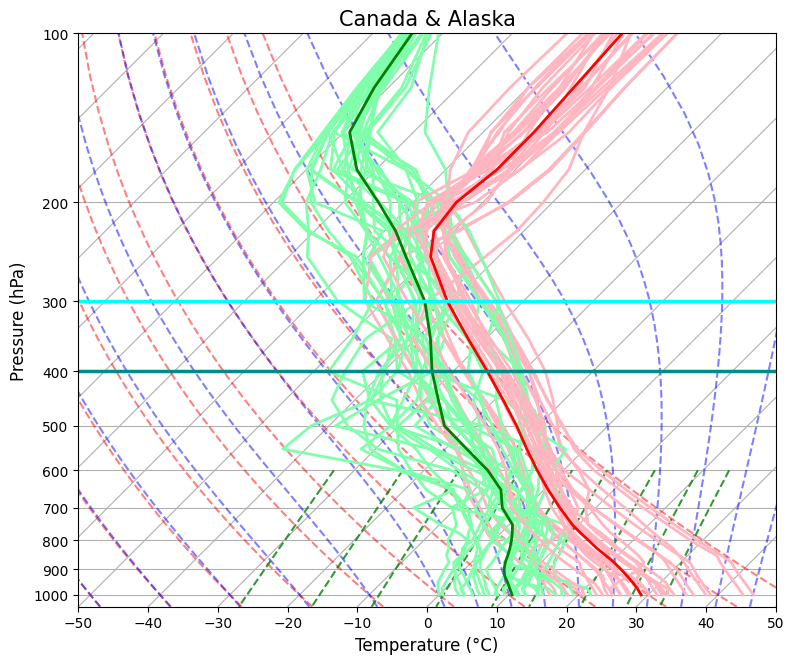

In [417]:
# Create a new figure. The 'figsize' argument can be adjusted as needed.
fig = plt.figure(figsize=(9, 9))

# Set up a SkewT plot
skew = SkewT(fig, rotation=45)

# Create a dummy temperature profile
# In reality, you would replace these with your actual atmospheric data.
p = np.array(subpfile.level) * units.hPa  # Pressure levels
#T = (np.array(subpfile.t)-273.15) * units.degC  # Temperature
#Td = T - (np.random.rand(10) * 10) * units.degC  # Dewpoint

# Add the relevant lines to the plot here
for profile in CAN_ALA:
 skew.plot(p, profile['T']-273.15, '#FFB6C1', linewidth=2)  # Plot the temperature profile
 skew.plot(p, profile['T_d'], '#7FFFAA', linewidth=2)  # Plot the dewpoint profile
skew.plot(p, np.array(CAN_ALA_T_sum)/len(CAN_ALA)-273.15, 'r', linewidth=2)  # Plot the temperature profile
skew.plot(p, np.array(CAN_ALA_Td_sum)/len(CAN_ALA), 'g',  linewidth=2) 
#skew.plot(p, T_ds2, 'b', linewidth=2)  # Plot the dewpoint profile

skew.ax.axhline(y=300, color='#00FFFF', linewidth=2.5)
skew.ax.axhline(y=400, color='#008B8B', linewidth=2.5)

# Other plot settings (like axis limits, etc.)
# Optionally, plot wind barbs
#wind_speed = wind_speeds * units.knots
#wind_direction = wind_dirs * units.degrees
#skew.plot_barbs(p, np.array(subpfile.u)* 1852 / 3600, np.array(subpfile.v)* 1852 / 3600, xloc=1.0)#need to convert to knot in advance

# Set some appropriate axes limits
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 50)

# Add the relevant meteorological lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add a title and some labels
plt.title('Canada & Alaska', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# Display the plot
plt.show()

save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/skewT/'
fig.savefig(save_dir+'CAN_ALA.pdf')

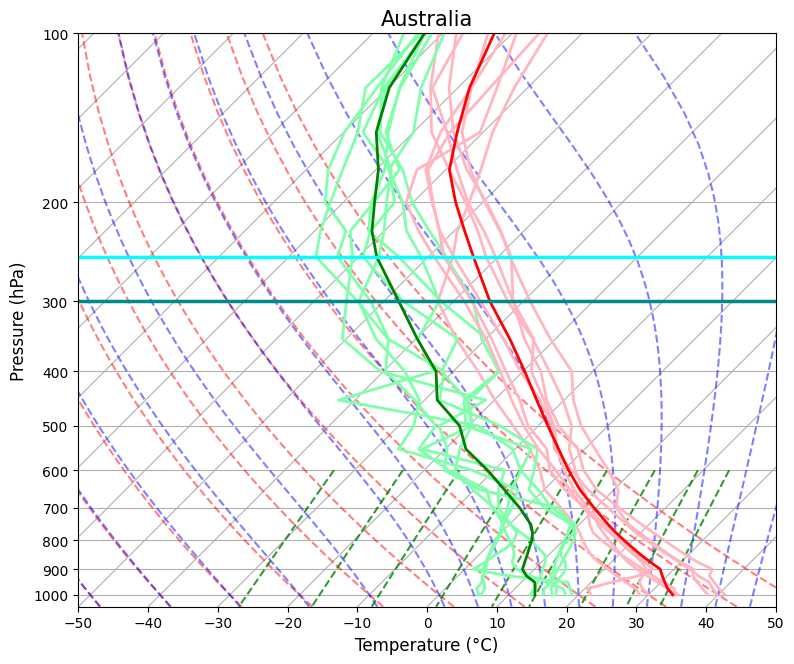

In [414]:
# Create a new figure. The 'figsize' argument can be adjusted as needed.
fig = plt.figure(figsize=(9, 9))

# Set up a SkewT plot
skew = SkewT(fig, rotation=45)

# Create a dummy temperature profile
# In reality, you would replace these with your actual atmospheric data.
p = np.array(subpfile.level) * units.hPa  # Pressure levels
#T = (np.array(subpfile.t)-273.15) * units.degC  # Temperature
#Td = T - (np.random.rand(10) * 10) * units.degC  # Dewpoint

# Add the relevant lines to the plot here
for profile in AUS:
 skew.plot(p, profile['T']-273.15, '#FFB6C1', linewidth=2)  # Plot the temperature profile
 skew.plot(p, profile['T_d'], '#7FFFAA',  linewidth=2)  # Plot the dewpoint profile
skew.plot(p, np.array(AUS_T_sum)/len(AUS)-273.15, 'r', linewidth=2)  # Plot the temperature profile
skew.plot(p, np.array(AUS_Td_sum)/len(AUS), 'g',  linewidth=2) 
#skew.plot(p, T_ds2, 'b', linewidth=2)  # Plot the dewpoint profile

skew.ax.axhline(y=250, color='#00FFFF', linewidth=2.5)
skew.ax.axhline(y=300, color='#008B8B', linewidth=2.5)

# Other plot settings (like axis limits, etc.)
# Optionally, plot wind barbs
#wind_speed = wind_speeds * units.knots
#wind_direction = wind_dirs * units.degrees
#skew.plot_barbs(p, np.array(subpfile.u)* 1852 / 3600, np.array(subpfile.v)* 1852 / 3600, xloc=1.0)#need to convert to knot in advance

# Set some appropriate axes limits
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 50)

# Add the relevant meteorological lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add a title and some labels
plt.title('Australia', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# Display the plot
plt.show()

save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/skewT/'
fig.savefig(save_dir+'AUS.pdf')

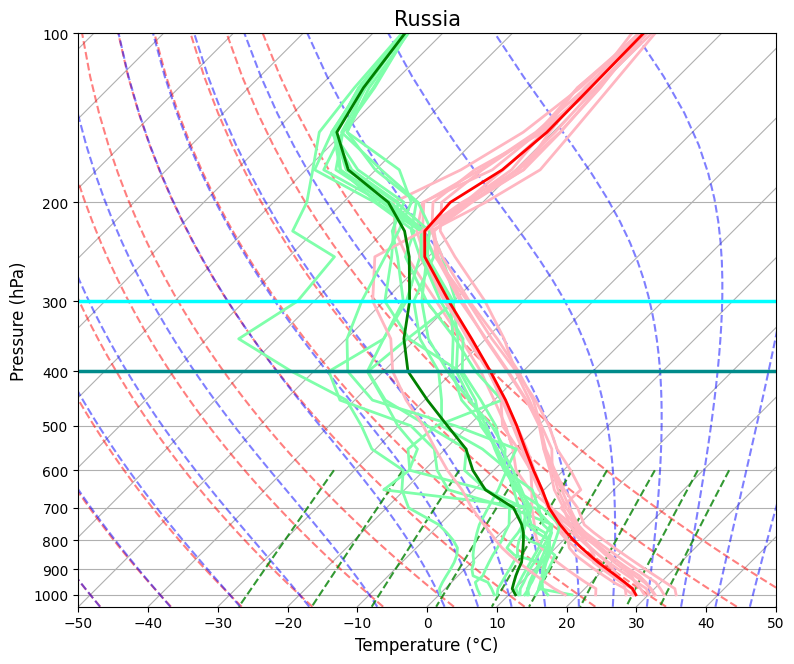

In [415]:
# Create a new figure. The 'figsize' argument can be adjusted as needed.
fig = plt.figure(figsize=(9, 9))

# Set up a SkewT plot
skew = SkewT(fig, rotation=45)

# Create a dummy temperature profile
# In reality, you would replace these with your actual atmospheric data.
p = np.array(subpfile.level) * units.hPa  # Pressure levels
#T = (np.array(subpfile.t)-273.15) * units.degC  # Temperature
#Td = T - (np.random.rand(10) * 10) * units.degC  # Dewpoint

# Add the relevant lines to the plot here
for profile in RUS:
 skew.plot(p, profile['T']-273.15, '#FFB6C1', linewidth=2)  # Plot the temperature profile
 skew.plot(p, profile['T_d'], '#7FFFAA', linewidth=2)  # Plot the dewpoint profile
skew.plot(p, np.array(RUS_T_sum)/len(RUS)-273.15, 'r', linewidth=2)  # Plot the temperature profile
skew.plot(p, np.array(RUS_Td_sum)/len(RUS), 'g',  linewidth=2) 
#skew.plot(p, T_ds2, 'b', linewidth=2)  # Plot the dewpoint profile

skew.ax.axhline(y=300, color='#00FFFF', linewidth=2.5)
skew.ax.axhline(y=400, color='#008B8B', linewidth=2.5)

# Other plot settings (like axis limits, etc.)
# Optionally, plot wind barbs
#wind_speed = wind_speeds * units.knots
#wind_direction = wind_dirs * units.degrees
#skew.plot_barbs(p, np.array(subpfile.u)* 1852 / 3600, np.array(subpfile.v)* 1852 / 3600, xloc=1.0)#need to convert to knot in advance

# Set some appropriate axes limits
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 50)

# Add the relevant meteorological lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add a title and some labels
plt.title('Russia', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# Display the plot
plt.show()

save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/skewT/'
fig.savefig(save_dir+'RUS.pdf')

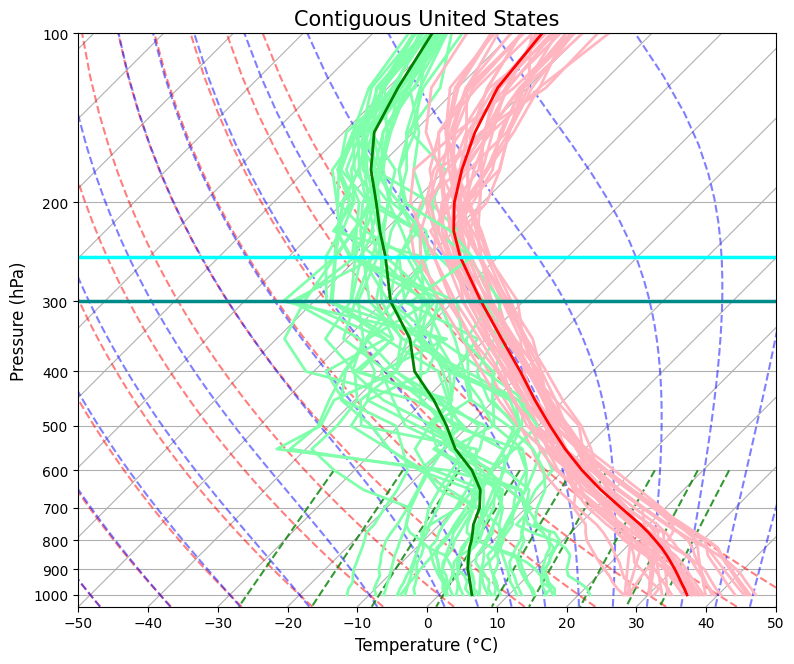

In [416]:
# Create a new figure. The 'figsize' argument can be adjusted as needed.
fig = plt.figure(figsize=(9, 9))

# Set up a SkewT plot
skew = SkewT(fig, rotation=45)

# Create a dummy temperature profile
# In reality, you would replace these with your actual atmospheric data.
p = np.array(subpfile.level) * units.hPa  # Pressure levels
#T = (np.array(subpfile.t)-273.15) * units.degC  # Temperature
#Td = T - (np.random.rand(10) * 10) * units.degC  # Dewpoint

# Add the relevant lines to the plot here
for profile in CUS:
 skew.plot(p, profile['T']-273.15, '#FFB6C1', linewidth=2)  # Plot the temperature profile
 skew.plot(p, profile['T_d'], '#7FFFAA', linewidth=2)  # Plot the dewpoint profile
skew.plot(p, np.array(CUS_T_sum)/len(CUS)-273.15, 'r', linewidth=2)  # Plot the temperature profile
skew.plot(p, np.array(CUS_Td_sum)/len(CUS), 'g',  linewidth=2) 
#skew.plot(p, T_ds2, 'b', linewidth=2)  # Plot the dewpoint profile

skew.ax.axhline(y=250, color='#00FFFF', linewidth=2.5)
skew.ax.axhline(y=300, color='#008B8B', linewidth=2.5)

# Other plot settings (like axis limits, etc.)
# Optionally, plot wind barbs
#wind_speed = wind_speeds * units.knots
#wind_direction = wind_dirs * units.degrees
#skew.plot_barbs(p, np.array(subpfile.u)* 1852 / 3600, np.array(subpfile.v)* 1852 / 3600, xloc=1.0)#need to convert to knot in advance

# Set some appropriate axes limits
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 50)

# Add the relevant meteorological lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add a title and some labels
plt.title('Contiguous United States', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# Display the plot
plt.show()

save_dir='/Users/liuyangfan/Desktop/Stanford/pyrocast-database/era5/analysis/skewT/'
fig.savefig(save_dir+'CUS.pdf')

In [265]:
# 5. get the variable, can't, need to decide for each time
# 6. do spatial and temporal interpolation to get the variable for the specific event
subpfile=pfile.interp(longitude=lon,latitude=lat,time=event_datetime)#by default is linear interp
# for upper troposphere divergence, find the tropopause
# Potential vorticity level (10-9 K m2 kg-1 s-1 or 10-3 PVU): 2000 (which is representative of the dynamical tropopause)
subpfile
## define the height for taupopause for each region after plotting their skew-T plots



In [283]:
subpfile

<xarray.Dataset>
Dimensions:    (level: 37)
Coordinates:
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
    longitude  float64 -155.6
    latitude   float64 63.3
    time       datetime64[ns] 2022-06-11T23:00:00
Data variables: (12/16)
    d          (level) float64 2.528e-05 -1.893e-05 ... -3.351e-05 -3.076e-05
    cc         (level) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    z          (level) float64 4.843e+05 4.29e+05 3.977e+05 ... 2.045e+03 -54.86
    o3         (level) float64 3.716e-06 5.419e-06 ... 6.263e-08 6.321e-08
    pv         (level) float64 0.00624 0.003333 ... -2.666e-06 -2.805e-06
    r          (level) float64 8.392e-05 8.392e-05 8.392e-05 ... 33.88 33.65
    ...         ...
    cswc       (level) float64 -1.819e-12 -1.819e-12 ... -1.819e-12 -1.819e-12
    t          (level) float64 276.2 274.8 263.8 255.7 ... 287.0 288.7 290.0
    u          (level) float64 -20.5 -18.45 -11.99 -12.61 ... 2.015 1.334 1.257
    v          (level) float64 8.651 -0.6157 5.9 2.94 ... 1.198 0.8318 0.7203
    w          (level) float64 -0.001207 0.001826 -4.404e-05 ... 0.02503 0.02956
    vo         (level) float64 3.131e-07 -2.069e-05 ... 4.632e-05 2.928e-05
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-24 19:55:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [275]:
# for surface pressure
## match the geopotential height in era5 single level and pressure level
sfile=xr.merge([xr.open_dataset(f) for f in glob.glob(s_path)])
subsfile=sfile.interp(longitude=lon,latitude=lat,time=event_datetime)
surface_g=subsfile.z.item()
surface_geoheight=surface_g/9.80665

In [404]:
subsfile

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float64 -155.6
    latitude   float64 63.3
    time       datetime64[ns] 2022-06-11T23:00:00
Data variables:
    cin        float64 nan
    z          float64 2.659e+03
    slhf       float64 -4.755e+05
    sshf       float64 -7.398e+05
    u10        float64 1.441
    v10        float64 0.8502
    fg10       float64 7.539
    blh        float64 2.132e+03
    cape       float64 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-24 20:27:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [361]:
wind_speeds=[]
wind_dirs=[]
T_ds=[]
T_ds2=[]
for i in list(range(0,37)):
    wind_speeds.append(wind_speed_knots(np.array(subpfile.u)[i],np.array(subpfile.v)[i]))
    wind_dirs.append(calculate_wind_direction(np.array(subpfile.u)[i],np.array(subpfile.v)[i]))
    T_ds.append(calculate_dew_point(np.array(subpfile.t)[i],np.array(subpfile.r)[i]))
    T_ds2.append(np.array(subpfile.t)[i]-(100-np.array(subpfile.r)[i])/5-273.15)

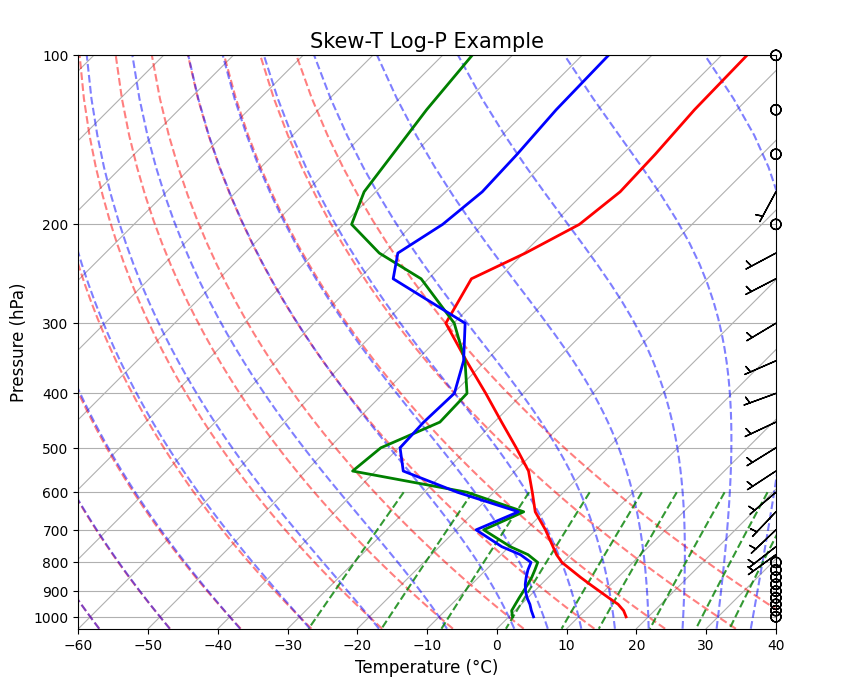

In [363]:
# Create a new figure. The 'figsize' argument can be adjusted as needed.
fig = plt.figure(figsize=(9, 9))

# Set up a SkewT plot
skew = SkewT(fig, rotation=45)

# Create a dummy temperature profile
# In reality, you would replace these with your actual atmospheric data.
p = np.array(subpfile.level) * units.hPa  # Pressure levels
T = (np.array(subpfile.t)-273.15) * units.degC  # Temperature
#Td = T - (np.random.rand(10) * 10) * units.degC  # Dewpoint

# Add the relevant lines to the plot here
skew.plot(p, T, 'r', linewidth=2)  # Plot the temperature profile
skew.plot(p, T_ds, 'g', linewidth=2)  # Plot the dewpoint profile
#skew.plot(p, T_ds2, 'b', linewidth=2)  # Plot the dewpoint profile

# Optionally, plot wind barbs
wind_speed = wind_speeds * units.knots
wind_direction = wind_dirs * units.degrees
skew.plot_barbs(p, np.array(subpfile.u)* 1852 / 3600, np.array(subpfile.v)* 1852 / 3600, xloc=1.0)#need to convert to knot in advance

# Set some appropriate axes limits
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-60, 40)

# Add the relevant meteorological lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add a title and some labels
plt.title('Skew-T Log-P Example', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# Display the plot
plt.show()